## MLFlow avec TensorFlow 2.0



In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score
import mlflow
import mlflow.tensorflow
from mlflow.models.signature import infer_signature
import os


In [17]:
print("TensorFlow: {}".format(tf.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("Numpy: {}".format(np.__version__))
print("MLFlow: {}".format(mlflow.__version__))
print("Matplotlib: {}".format(matplotlib.__version__))


TensorFlow: 2.20.0
Scikit-Learn: 1.7.2
Numpy: 2.3.5
MLFlow: 3.6.0
Matplotlib: 3.10.7


In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [19]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Class:  5


(<matplotlib.image.AxesImage at 0x7f0cb44b6d50>, None)

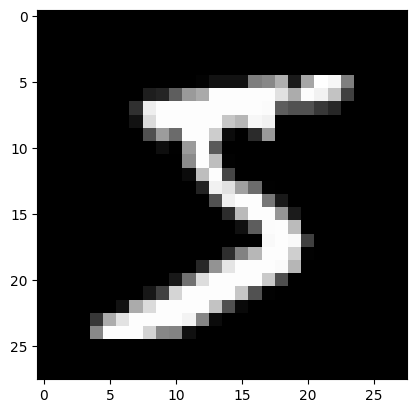

In [20]:
plt.imshow(x_train[0], cmap='gray'), print("Class: ", y_train[0])


Notez également que les étiquettes sont toutes des nombres entiers compris entre 0 et 9, chacune associée à une image qui montre un chiffre manuscrit de 0 à 9. 

Étant donné que les couches convolutives 2D dans TensorFlow/Keras s'attendent à quatre dimensions au format (m, h, w, c) où m représente le nombre d'échantillons dans l'ensemble de données, h et w représentent respectivement la hauteur et la largeur, et c représente le nombre de canaux (trois s'il s'agit d'une image couleur RGB par exemple), vous devez remodeler vos données afin qu'elles soient conformes à ces spécifications. Vos images sont toutes en noir et blanc, elles en ont donc techniquement 1 canal. Et donc, vous devez les remodeler comme ceci : 

In [21]:
y_train[0]


np.uint8(5)

In [22]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],
x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],
x_test.shape[2], 1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


In [23]:
y_train[0] # This is a one-hot encoded vector, notice that at index 5 the value is 1


array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [24]:
print("Shapes")
print("x_train: {}\ny_train: {}".format(x_train.shape,
y_train.shape))
print("x_test: {}\ny_test: {}".format(x_test.shape,
y_test.shape))


Shapes
x_train: (60000, 28, 28, 1)
y_train: (60000, 10)
x_test: (10000, 28, 28, 1)
y_test: (10000, 10)


### MLFlow run - training and evaluating 

Nous allons créer notre modèle en utilisant la méthode séquentielle de création de modèle. Le modèle sera assez simple,
composé de quelques couches convolutives 2D qui alimentent trois couches denses. 

In [ ]:
model = Sequential()

model.add(Input(shape=(28, 28, 1)))

model.add(Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation="relu"))
model.add(Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation="relu"))
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │        11,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,940 (54.45 KB)

 Trainable params: 13,940 (54.45 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(optimizer="Adam",loss="categorical_crossentropy", metrics=["accuracy"])


Nous allons maintenant dire à MLFlow de loger ce run. nous souhaitons que toutes les métriques soient enregistrées dans la même exécution, vous devez donc indiquer spécifiquement à MLFlow d'exécuter un bloc de code dans le contexte de la même exécution. 

In [31]:
if x_train.ndim == 3:
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

mlflow.set_experiment("TF_Keras_MNIST")
mlflow.tensorflow.autolog(log_models=False)

with mlflow.start_run():
    model.fit(x=x_train, y=y_train, batch_size=256, epochs=10)

    preds_prob = model.predict(x_test)
    preds_classes = np.argmax(preds_prob, axis=1)
    
    eval_acc = model.evaluate(x_test, y_test)[1]
    
    try:
        auc_score = roc_auc_score(y_test, preds_prob, multi_class='ovr')
    except ValueError:
        auc_score = 0.0
        print("Skipping AUC calculation due to label format.")

    print("eval_acc: ", eval_acc)
    print("auc_score: ", auc_score)

    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)

    input_sample = x_test[:5]
    prediction_sample = model.predict(input_sample)
    signature = infer_signature(input_sample, prediction_sample)

    mlflow.tensorflow.log_model(
        model, 
        name="model",
        signature=signature,
        input_example=input_sample
    )

mlflow.end_run()


Epoch 1/10
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9959 - loss: 0.0116

2025/12/02 14:36:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9953 - loss: 0.0138
Epoch 2/10
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9952 - loss: 0.0130

2025/12/02 14:36:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9944 - loss: 0.0157
Epoch 3/10
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9947 - loss: 0.0142

2025/12/02 14:36:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9951 - loss: 0.0140
Epoch 4/10
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9966 - loss: 0.0097

2025/12/02 14:36:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9961 - loss: 0.0118
Epoch 5/10
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9965 - loss: 0.0108

2025/12/02 14:36:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9965 - loss: 0.0103
Epoch 6/10
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0095

2025/12/02 14:36:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9956 - loss: 0.0120
Epoch 7/10
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9961 - loss: 0.0100

2025/12/02 14:36:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9955 - loss: 0.0118
Epoch 8/10
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9977 - loss: 0.0067

2025/12/02 14:36:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9974 - loss: 0.0079
Epoch 9/10
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9968 - loss: 0.0098

2025/12/02 14:36:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9964 - loss: 0.0113
Epoch 10/10
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9963 - loss: 0.0115

2025/12/02 14:36:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9962 - loss: 0.0112
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9756 - loss: 0.1380
eval_acc:  0.975600004196167
auc_score:  0.9995713791178341
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


la ligne mlflow.keras.autolog() 

Cela indique essentiellement à MLFlow d'enregistrer tous les paramètres et métriques associés au modèle TensorFlow/Keras. Comme vous le verrez dans peu de temps, MLFlow enregistrera les hyperparamètres, les métriques du modèle répertoriées dans la fonction compile() et même le modèle lui-même une fois l'entraînement terminé. 

### MLFlow UI 

ouvrons maintenant l'interface utilisateur de MLFlow et vérifions notre run. Assurez-vous que votre terminal ou invite de commande se trouve dans le même répertoire que celui où les mlruns sont stockés.

![image.png](attachments/notebook2/image.png)

En cliquant sur le run, vous allez remarqué que MLFlow a enregistré tous les hyperparamètres utilisés lors de la création du modèle. Cela peut être très utile pour le réglage des hyperparamètres sur un ensemble de validation, par exemple, lorsque vous essayez de régler plusieurs hyperparamètres à la fois. Par exemple, vous pouvez certainement régler batch_size, epochs ou quelque chose lié à l'optimiseur Adam comme opt_learning_rate, opt_beta_1 ou opt_beta_2. 

Dans la partie artifacts en bas, vous allez remqrquer que MLflow a enregistré le modèle aussi, l'évnement Tensorboard et le summary du modèle 

### Model loading 

copiez l'ID du run 

In [35]:
loaded_model = mlflow.tensorflow.load_model("runs:/df2c94b8659b4462b19ed32aa60beb45/model")


Vous remarquerez que nous avons fait mlflow.keras au lieu de mlflow.tensorflow. C'est parce que ce modèle est techniquement un modèle Keras, et donc il est conforme au code load_model() spécifique dans le module mlflow.keras. 

In [36]:
eval_loss, eval_acc = loaded_model.evaluate(x_test, y_test)
preds = loaded_model.predict(x_test)
preds = np.round(preds)
eval_auc = roc_auc_score(y_test, preds)
print("Eval Loss:", eval_loss)
print("Eval Acc:", eval_acc)
print("Eval AUC:", eval_auc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9756 - loss: 0.1380
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Eval Loss: 0.13795781135559082
Eval Acc: 0.975600004196167
Eval AUC: 0.9862037364566314


Comme vous pouvez le voir, cette sortie correspond aux valeurs de la sortie de l'exécution précédente. De plus, ce modèle est également fonctionnel et peut faire des prédictions. 